# BEE 4750 Homework 5: Solid Waste Disposal

**Name**: Anthony Nicolaides

**ID**: ajn68

> **Due Date**
>
> Friday, 11/10/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/Julia/BEE4750/hw/hw05-anthonynic28`


In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Background

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided in the table below.

|    **Disposal Facility**     | **Capacity** (Mg/d) | **Fixed cost** (\$/d) | **Tipping Fee**  (\$/Mg) | **Recycling Cost** (\$/Mg) |
|:----------------------------:|:-------------------:|:---------------------:|:------------------------:|:--------------------------:|
|           Landfill           |         200         |         2000          |            50            |              -             |
| Materials Recycling Facility |         350         |         1500          |            7             |    40 (per Mg recycled)    |
|   Waste-to-Energy Facility   |         210         |         2500          |            60            |              -             |

Transportation costs are \$1.5/Mg-km, and the relative distances between
the cities and facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

|   **Component**   | **% of total mass** | **Combustion ash** (%) | **MRF Recycling rate** (%) |
|:-----------------:|:-------------------:|:----------------------:|:--------------------------:|
|    Food Wastes    |         15          |           8            |             0              |
| Paper & Cardboard |         40          |           7            |             55             |
|     Plastics      |          5          |           5            |             15             |
|     Textiles      |          3          |           10           |             10             |
|  Rubber, Leather  |          2          |           15           |             0              |
|       Wood        |          5          |           2            |             30             |
|    Yard Wastes    |         18          |           2            |             40             |
|       Glass       |          4          |          100           |             60             |
|      Ferrous      |          2          |          100           |             75             |
|     Aluminum      |          2          |          100           |             80             |
|    Other Metal    |          1          |          100           |             50             |
|   Miscellaneous   |          3          |           70           |             0              |

The information in the above table will help you determine the overall
recycling and ash fractions. Note that the recycling residuals, which
may be sent to either landfill or the WTE, have different ash content
than the ash content of the original MSW. You will need to determine
these fractions to construct your mass balance constraints.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

## Problems (Total: 40 Points)

### Problem 1 (22 points)

In this problem, you will develop an optimal disposal plan for the two
cities.

#### Problem 1.1 (3 points)

Based on the information above, calculate the overall recycling and ash
fractions for the waste produced by each city.

In [3]:
WTE_dict = Dict{String,Int}(
    "capacity" => 210, # Mg / d
    "fixed cost" => 2500, # USD / d
    "tipping fee" => 60, # USD / Mg
    "WTE distance" => 0, # km
    "MRF distance" => 15, # km
    "LF distance" => 18, # km
)

MRF_dict = Dict{String,Int}(
    "capacity" => 350, # Mg / d
    "fixed cost" => 1500, # USD / d
    "tipping fee" => 7, # USD / Mg
    "recycling cost" => 40, # USD / recycled Mg
    "WTE distance" => 15, # km
    "MRF distance" => 0, # km
    "LF distance" => 32, # km
)

LF_dict = Dict{String,Int}(
    "capacity" => 200, # Mg / d
    "fixed cost" => 2000, # USD / d
    "tipping fee" => 50, # USD / Mg
    "WTE distance" => 18, # km
    "MRF distance" => 32, # km
    "LF distance" => 0, # km
)

city1_dict = Dict{String,Int}(
    "production" => 100, # Mg / day
    "WTE distance" => 15, # km
    "MRF distance" => 30, # km
    "LF distance" => 5 # km
)

city2_dict = Dict{String,Int}(
    "production" => 90, # Mg / day
    "WTE distance" => 10, # km
    "MRF distance" => 25, # km
    "LF distance" => 15 # km
)

city3_dict = Dict{String,Int}(
    "production" => 120, # Mg / day
    "WTE distance" => 20, # km
    "MRF distance" => 45, # km
    "LF distance" => 13 # km
)

transportationCost = 1.5 # USD / Mg-km

totalMass_dict = Dict{String,Float64}( # percent of total
    "food wastes" => 0.15,
    "papers & cardboard" => 0.40,
    "plastics" => 0.05,
    "textiles" => 0.03,
    "rubber & leather" => 0.02,
    "wood" => 0.05,
    "yard wastes" => 0.18,
    "glass" => 0.04,
    "ferrous" => 0.02,
    "aluminum" => 0.02,
    "other metals" => 0.01,
    "miscellaneous" => 0.03,
)
totalMass_dict = sort(totalMass_dict)

combustionAsh_dict = Dict{String,Float64}( # percent of total
    "food wastes" => 0.08,
    "papers & cardboard" => 0.07,
    "plastics" => 0.05,
    "textiles" => 0.10,
    "rubber & leather" => 0.15,
    "wood" => 0.02,
    "yard wastes" => 0.02,
    "glass" => 1.0,
    "ferrous" => 1.0,
    "aluminum" => 1.0,
    "other metals" => 1.0,
    "miscellaneous" => 0.70,
)
combustionAsh_dict = sort(combustionAsh_dict)

MRFrecyclingRate_dict = Dict{String,Float64}( # percent of total
    "food wastes" => 0.0,
    "papers & cardboard" => 0.55,
    "plastics" => 0.15,
    "textiles" => 0.10,
    "rubber & leather" => 0,
    "wood" => 0.30,
    "yard wastes" => 0.40,
    "glass" => 0.60,
    "ferrous" => 0.75,
    "aluminum" => 0.80,
    "other metals" => 0.50,
    "miscellaneous" => 0.0,
)
MRFrecyclingRate_dict = sort(MRFrecyclingRate_dict);

In [4]:
totalMass_recycled = round(sum(collect(values(MRFrecyclingRate_dict)) .*
                               collect(values(totalMass_dict))), digits=7)
totalMass_ash = round(sum(collect(values(combustionAsh_dict)) .*
                          collect(values(totalMass_dict))), digits=7)
println("Fraction of MRF waste that gets recycled: ", totalMass_recycled)
println("Fraction of WTE waste that turns to residual ash: ", totalMass_ash)

Fraction of MRF waste that gets recycled: 0.3775
Fraction of WTE waste that turns to residual ash: 0.1641


#### Problem 1.2 (2 points)

What are the decision variables for your optimization problem? Provide
notation and variable meaning.

| **Decision Variable** | **Meaning** | **Unit** |
|:------------:|:-----------:|:--------:|
|   W<sub>i,j</sub>      | Waste transported from city i to disposal j | Mg/day |
|   R<sub>d,j</sub>      | Residual waste transported from disposal d to disposal j | Mg/day |
|   Y<sub>j</sub>        | Operational status (on/off) of disposal | binary |


#### Problem 1.3 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s).

| **Variable** | **Meaning** | **Unit** |
|:------------:|:-----------:|:--------:|
|   a<sub>i,j</sub>      | Cost of transporting waste from source i to disposal j | \$/Mg-km |
|   l<sub>i,j</sub>      | Distance between source i and disposal j | km |
|   c<sub>j</sub>        | Fixed costs of operating disposal j | \$/day |
|   b<sub>j</sub>        | Variable cost of disposing waste at disposal j | \$/Mg |
|   S<sub>i</sub>        | Waste at source i | Mg/day |
|   K<sub>j</sub>        | Capacity limit at disposal j | Mg/d |

\begin{equation}
\begin{aligned}
\sum_{i \in \mathcal{I}, j \in \mathcal{J}}(a_i,_j * l_i,_j * W_i,_j)
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\sum_{j \in \mathcal{J}}[c_j + b_j\sum_{i \in \mathcal{I}} (W_i,_j)]
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\sum_{j \in \mathcal{J}}[(c_j * Y_j) + b_j\sum_{i \in \mathcal{I}} (W_i,_j)]
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
& \min_{W_i,_j, Y_j} &  \sum_{i \in \mathcal{I}, j \in \mathcal{J}} (a_i,_j * l_i,_j * W_i,_j) + \\
& & \sum_{j \in \mathcal{J}} [(c_j * Y_j) + b_j \sum_{i \in \mathcal{I}} (W_i,_j)]
\end{aligned}
\end{equation}

#### Problem 1.4 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

\begin{equation}
\begin{aligned}
& Y_j = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_j) = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_j) > 0 \end{cases}
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\sum_{j \in \mathcal{J}} (W_i,_j) = S_i
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
\sum_{i \in \mathcal{I}} (W_i,_j) \leq K_j
\end{aligned}
\end{equation}


\begin{equation}
\begin{aligned}
W_i,_j \geq 0
\end{aligned}
\end{equation}

The complete objective function with constraints:

\begin{equation}
\begin{aligned}
& \min_{W_i,_j, Y_j} &  \sum_{i \in \mathcal{I}, j \in \mathcal{J}} (a_i,_j * l_i,_j * W_i,_j) + \\
& & \sum_{j \in \mathcal{J}} [(c_j * Y_j) + b_j \sum_{i \in \mathcal{I}} (W_i,_j)] \\
&\text{subject to} & \\
& & Y_j = \begin{cases} 0 & \text{if } \sum_{i \in \mathcal{I}} (W_i,_j) = 0 \\ 
1 & \text{else} \sum_{i \in \mathcal{I}} (W_i,_j) > 0 \end{cases} \\
& & \sum_{j \in \mathcal{J}} (W_i,_j) = S_i \\
& & \sum_{i \in \mathcal{I}} (W_i,_j) \leq K_j \\
& & W_i,_j \geq 0
\end{aligned}
\end{equation}

#### Problem 1.5 (3 points)

Implement your optimization problem in `JuMP`.

In [5]:
# define sets
I = 1:3 # three sources
J = 1:3 # three disposals
H = 1:3 # disposal can send to the other disposals

# define indices
WTE = 1
MRF = 2
LF = 3
city1 = 1
city2 = 2
city3 = 3

#=
i,j -------------------------
        WTE    MRF     LF
city1   W1,1    W1,2    W1,3
city2   W2,1    W2,2    W2,3
city3   W3,1    W3,2    W3,3

        WTE    MRF     LF
city1   a1,1    a1,2    a1,3
city2   a2,1    a2,2    a2,3
city3   a3,1    a3,2    a3,3

        WTE    MRF     LF
city1   l1,1    l1,2    l1,3
city2   l2,1    l2,2    l2,3
city3   l3,1    l3,2    l3,3
-----------------------------
h,j -------------------------
        WTE    MRF     LF
WTE      R1,1    R1,2    R1,3
MRF     R2,1    R2,2    R2,3
LF     R3,1    R3,2    R3,3
-----------------------------
j ---------------------------
WTE      Y1, K1, c1, b1
MRF     Y2, K2, c2, b2
LF     Y3, K3, c3, b3
-----------------------------
i ---------------------------
city1   S1
city2   S2
city3   S3
-----------------------------
=#

waste_model = Model(HiGHS.Optimizer)

# variable notation for non-decision variables
M = 1.9e14 # Big-M notation
WTE_residual_ash = totalMass_ash
MRF_recycling_rate = totalMass_recycled

a = zeros(6, 3) .+ transportationCost # USD / Mg-km
b = [WTE_dict["tipping fee"] MRF_dict["tipping fee"] LF_dict["tipping fee"]] # USD/Mg
c = [WTE_dict["fixed cost"] MRF_dict["fixed cost"] LF_dict["fixed cost"]] # km
d = [0 MRF_dict["recycling cost"] 0]
e = [0 MRF_recycling_rate 0]
l = [ # km from source i or disposal h (h=i+3) to disposal j
    city1_dict["WTE distance"] city1_dict["MRF distance"] city1_dict["LF distance"]
    city2_dict["WTE distance"] city2_dict["MRF distance"] city2_dict["LF distance"]
    city3_dict["WTE distance"] city3_dict["MRF distance"] city3_dict["LF distance"]
    WTE_dict["WTE distance"] WTE_dict["MRF distance"] WTE_dict["LF distance"]
    MRF_dict["WTE distance"] MRF_dict["MRF distance"] MRF_dict["LF distance"]
    LF_dict["WTE distance"] LF_dict["MRF distance"] LF_dict["LF distance"]
]
K = [WTE_dict["capacity"] MRF_dict["capacity"] LF_dict["capacity"]]
S = [city1_dict["production"]
    city2_dict["production"]
    city3_dict["production"]]
cities = length(S) # to offset l when indexing for h instead of i

# decision variables
@variable(waste_model, W[i in I, j in J] >= 0) # 
@variable(waste_model, R[h in H, j in J] >= 0) # 
@variable(waste_model, Y[j in J], binary = true) # 

# constraints
@constraint(waste_model, constraint_waste[i in I],
    sum(W[i, j] for j in J) == S[i]) # waste constraint

@constraint(waste_model, constraint_mass1,
    R[WTE, LF] ==
    WTE_residual_ash * (sum(W[i, WTE] for i in I) + R[MRF, WTE]))

@constraint(waste_model, constraint_mass2,
    R[MRF, WTE] + R[MRF, LF] ==
    (1 - MRF_recycling_rate) * sum(W[i, MRF] for i in I))

@constraint(waste_model, constraint_capacity1,
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= K[WTE])

@constraint(waste_model, constraint_capacity2,
    sum(W[i, MRF] for i in I) <= K[MRF])

@constraint(waste_model, constraint_capacity3,
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= K[LF])

@constraint(waste_model, constraint_operating1,
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= M * Y[WTE])

@constraint(waste_model, constraint_operating2,
    sum(W[i, MRF] for i in I) <= M * Y[MRF])

@constraint(waste_model, constraint_operating3,
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= M * Y[LF])

@objective(waste_model, Min,
    sum(
        sum(
            (((d[j] * e[j]) + (a[i, j] * l[i, j]) + b[j]) *
             W[i, j]) for i in I) +
        sum(
            (((d[j] * e[j]) + (a[h+cities, j] * l[h+cities, j]) + b[j]) *
             R[h, j]) for h in H) +
        (c[j] * Y[j]) for j in J)
)


82.5 W[1,1] + 75 W[2,1] + 90 W[3,1] + 60 R[1,1] + 82.5 R[2,1] + 87 R[3,1] + 2500 Y[1] + 67.1 W[1,2] + 59.6 W[2,2] + 89.6 W[3,2] + 44.6 R[1,2] + 22.1 R[2,2] + 70.1 R[3,2] + 1500 Y[2] + 57.5 W[1,3] + 72.5 W[2,3] + 69.5 W[3,3] + 77 R[1,3] + 98 R[2,3] + 50 R[3,3] + 2000 Y[3]

#### Problem 1.6 (2 points)

Find the optimal solution. Report the optimal objective value.

In [6]:
optimize!(waste_model)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
10 rows, 15 cols, 43 nonzeros
8 rows, 13 cols, 35 nonzeros

Solving MIP model with:
   8 rows
   13 cols (2 binary, 0 integer, 0 implied int., 11 continuous)
   35 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   2000            inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   2000            27855.482115      92.82%        0      0      0         0     0.0s
         0       0         0   0.00%   26009.563771    27855.482115       6.63%        0      0      0         5     0.0s

Solving report
  Status            Optimal
  Primal bound      27855.4821151
  Dual bound        27855.4821151
  Gap           

In [7]:
objective_value(waste_model)

27855.48211508554

In [8]:
value.(W).data

3×3 Matrix{Float64}:
  0.0      0.0  100.0
 90.0     -0.0   -0.0
 41.5947   0.0   78.4053

In [9]:
value.(R).data

3×3 Matrix{Float64}:
 0.0  0.0  21.5947
 0.0  0.0   0.0
 0.0  0.0   0.0

In [10]:
value.(Y).data

3-element Vector{Float64}:
  1.0
 -0.0
  1.0

#### Problem 1.7 (5 points)

Draw a diagram showing the flows of waste between the cities and the
facilities. Which facilities (if any) will not be used? Does this
solution make sense?

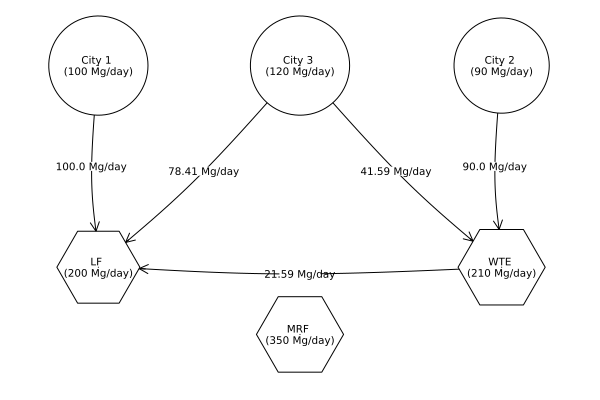

In [11]:
names = [
    "City 1 \n(" * string(city1_dict["production"], " Mg/day)"),
    "City 2 \n(" * string(city2_dict["production"], " Mg/day)"),
    "City 3 \n(" * string(city3_dict["production"], " Mg/day)"),
    "WTE \n(" * string(WTE_dict["capacity"], " Mg/day)"),
    "MRF \n(" * string(MRF_dict["capacity"], " Mg/day)"),
    "LF \n(" * string(LF_dict["capacity"], " Mg/day)")
]

shapes = [:circle, :circle, :circle, :hexagon, :hexagon, :hexagon]
colors = [:white, :white, :white, :white, :white, :white]
sizes = 0.15
xpos = [-0.5, 2.5, 1, 2.5, 1, -0.5]
ypos = [1, 1, 1, -0.5, -1, -0.5]

W = round.(value.(W).data, digits=2)
R = round.(value.(R).data, digits=2)
edge_labels = Dict(
    (city1, LF + cities) => string(value.(W[city1, LF]), " Mg/day"),
    (city2, WTE + cities) => string(value.(W[city2, WTE]), " Mg/day"),
    (city3, WTE + cities) => string(value.(W[city3, WTE]), " Mg/day"),
    (city3, LF + cities) => string(value.(W[city3, LF]), " Mg/day"),
    (WTE + cities, LF + cities) => string(value.(R[WTE, LF]), " Mg/day")
)
A = zeros(length(names), length(names))
[A[i[1], i[2]] = 1 for i in collect(keys(edge_labels))]

graphplot(A,
    names=names,
    edgelabel=edge_labels,
    markersizes=sizes,
    markershapes=shapes,
    markercolor=colors,
    x=xpos, y=ypos
)

### Problem 2 (18 points)

It is projected that in the near future the state will introduce a
carbon tax that will increase the cost for transportation and for
disposal by incineration. It is estimated that the additional costs will
be:

-   tipping fee for the WTE facility will increase to\$75/Mg; and
-   transportation costs will increase to \$2/Mg-km.

In this context, the cities are considering adding another landfill and
want to know if this would be cost-effective compared to using the
current facilities with the carbon tax. This landfill would have a
maximum capacity of 100 Mg/day and would be located with the following
distances from the existing sites (excluding LF1):

| **City/Facility** | **Distance to LF2 (km)** |
|:-----------------:|:------------------------:|
|         1         |            45            |
|         2         |            35            |
|         3         |            15            |
|        MRF        |            35            |
|        WTE        |            50            |

The fixed cost of operating this facility would be the same as the first
landfill, but the tipping cost would be increased to \$60/Mg-day.

#### Problem 2.1 (5 points)

What changes are needed to your optimization program from Problem 1 for
this decision problem? Formulate any different variables, objectives,
and/or constraints.

In [17]:
WTE_dict["tipping fee"] = 75
transportationCost = 2
city1_dict["LF2 distance"] = 45
city2_dict["LF2 distance"] = 35
city3_dict["LF2 distance"] = 15
WTE_dict["LF2 distance"] = 50
MRF_dict["LF2 distance"] = 35
LF_dict["LF2 distance"] = 1e14

LF2_dict = Dict{String, Int64}(
    "capacity" => 100,
    "tipping fee" => 60,
    "fixed cost" => LF_dict["fixed cost"],
    "WTE distance" => 50,
    "MRF distance" => 35,
    "LF distance" => 1e14,
    "LF2 distance" => 0,
)

Dict{String, Int64} with 7 entries:
  "fixed cost"   => 2000
  "WTE distance" => 50
  "MRF distance" => 35
  "LF distance"  => 100000000000000
  "LF2 distance" => 0
  "tipping fee"  => 60
  "capacity"     => 100

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [34]:
# define sets
I = 1:3 # three sources
J = 1:4 # four disposals
H = J # disposal can send to the other disposals

# define indices
WTE = 1
MRF = 2
LF = 3
LF2 = 4
city1 = 1
city2 = 2
city3 = 3


waste_model = Model(HiGHS.Optimizer)

# variable notation for non-decision variables
M = 1.9e14 # Big-M notation
WTE_residual_ash = totalMass_ash
MRF_recycling_rate = totalMass_recycled

a = zeros(7, 4) .+ transportationCost # USD / Mg-km
b = [WTE_dict["tipping fee"] MRF_dict["tipping fee"] LF_dict["tipping fee"] LF2_dict["tipping fee"]] # USD/Mg
c = [WTE_dict["fixed cost"] MRF_dict["fixed cost"] LF_dict["fixed cost"] LF2_dict["fixed cost"]] # km
d = [0 MRF_dict["recycling cost"] 0 0]
e = [0 MRF_recycling_rate 0 0]
l = [ # km from source i or disposal h (h=i+3) to disposal j
    city1_dict["WTE distance"] city1_dict["MRF distance"] city1_dict["LF distance"] city1_dict["LF2 distance"]
    city2_dict["WTE distance"] city2_dict["MRF distance"] city2_dict["LF distance"] city2_dict["LF2 distance"]
    city3_dict["WTE distance"] city3_dict["MRF distance"] city3_dict["LF distance"] city3_dict["LF2 distance"]
    WTE_dict["WTE distance"] WTE_dict["MRF distance"] WTE_dict["LF distance"]  WTE_dict["LF2 distance"]
    MRF_dict["WTE distance"] MRF_dict["MRF distance"] MRF_dict["LF distance"]  MRF_dict["LF2 distance"]
    LF_dict["WTE distance"] LF_dict["MRF distance"] LF_dict["LF distance"] LF_dict["LF2 distance"]
    LF2_dict["WTE distance"] LF2_dict["MRF distance"] LF2_dict["LF distance"] LF2_dict["LF2 distance"]
]
K = [WTE_dict["capacity"] MRF_dict["capacity"] LF_dict["capacity"] LF2_dict["capacity"]]
S = [city1_dict["production"]
    city2_dict["production"]
    city3_dict["production"]]
cities = length(S) # to offset l when indexing for h instead of i

# decision variables
@variable(waste_model, W[i in I, j in J] >= 0) # 
@variable(waste_model, R[h in H, j in J] >= 0) # 
@variable(waste_model, Y[j in J], binary = true) # 

# constraints
@constraint(waste_model, constraint_waste[i in I],
    sum(W[i, j] for j in J) == S[i]) # waste constraint

@constraint(waste_model, constraint_mass1,
    R[WTE, LF] + R[WTE, LF2] ==
    WTE_residual_ash * (sum(W[i, WTE] for i in I) + R[MRF, WTE]))

@constraint(waste_model, constraint_mass2,
    R[MRF, WTE] + R[MRF, LF] + R[MRF, LF2] ==
    (1 - MRF_recycling_rate) * sum(W[i, MRF] for i in I))

@constraint(waste_model, constraint_capacity1,
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= K[WTE])

@constraint(waste_model, constraint_capacity2,
    sum(W[i, MRF] for i in I) <= K[MRF])

@constraint(waste_model, constraint_capacity3,
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= K[LF])

@constraint(waste_model, constraint_capacity4,
    sum(W[i, LF2] for i in I) + R[MRF, LF2] + R[WTE, LF2] <= K[LF2])

@constraint(waste_model, constraint_operating1,
    sum(W[i, WTE] for i in I) + R[MRF, WTE] <= M * Y[WTE])

@constraint(waste_model, constraint_operating2,
    sum(W[i, MRF] for i in I) <= M * Y[MRF])

@constraint(waste_model, constraint_operating3,
    sum(W[i, LF] for i in I) + R[MRF, LF] + R[WTE, LF] <= M * Y[LF])

@constraint(waste_model, constraint_operating4,
    sum(W[i, LF2] for i in I) + R[MRF, LF2] + R[WTE, LF2] <= M * Y[LF2])

@objective(waste_model, Min,
    sum(
        sum(
            (((d[j] * e[j]) + (a[i, j] * l[i, j]) + b[j]) *
             W[i, j]) for i in I) +
        sum(
            (((d[j] * e[j]) + (a[h+cities, j] * l[h+cities, j]) + b[j]) *
             R[h, j]) for h in H) +
        (c[j] * Y[j]) for j in J)
)


105 W[1,1] + 95 W[2,1] + 115 W[3,1] + 75 R[1,1] + 105 R[2,1] + 111 R[3,1] + 175 R[4,1] + 2500 Y[1] + 82.1 W[1,2] + 72.1 W[2,2] + 112.1 W[3,2] + 52.1 R[1,2] + 22.1 R[2,2] + 86.1 R[3,2] + 92.1 R[4,2] + 1500 Y[2] + 60 W[1,3] + 80 W[2,3] + 76 W[3,3] + 86 R[1,3] + 114 R[2,3] + 50 R[3,3] + 200000000000050 R[4,3] + 2000 Y[3] + 150 W[1,4] + 130 W[2,4] + 90 W[3,4] + 160 R[1,4] + 130 R[2,4] + 200000000000060 R[3,4] + 60 R[4,4] + 2000 Y[4]

#### Problem 2.3 (5 points)

Find the optimal solution and report the optimal objective value.
Provide a diagram showing the new waste flows.

In [35]:
optimize!(waste_model)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
12 rows, 21 cols, 59 nonzeros
12 rows, 21 cols, 59 nonzeros

Solving MIP model with:
   12 rows
   21 cols (4 binary, 0 integer, 0 implied int., 17 continuous)
   59 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   0               30568.278502     100.00%        0      0      0         0     0.0s
         0       0         0   0.00%   25226.469325    30568.278502      17.48%        0      0      0         8     0.0s

25.0% inactive integer columns, restarting
Model after restart has 11 rows, 20 cols (3 bin., 0 int., 0 impl., 17 cont.), and 

In [36]:
objective_value(waste_model)

30568.278502213183

In [37]:
value.(W).data

3×4 Matrix{Float64}:
  0.0      0.0  100.0       0.0
 11.9632  -0.0   78.0368    0.0
  0.0      0.0   20.0     100.0

In [38]:
value.(R).data

4×4 Matrix{Float64}:
 0.0  0.0  1.96315  0.0
 0.0  0.0  0.0      0.0
 0.0  0.0  0.0      0.0
 0.0  0.0  0.0      0.0

In [39]:
value.(Y).data

4-element Vector{Float64}:
  1.0
 -0.0
  1.0
  1.0

In [40]:
W = round.(value.(W).data, digits=2)
R = round.(value.(R).data, digits=2)

4×4 Matrix{Float64}:
 0.0  0.0  1.96  0.0
 0.0  0.0  0.0   0.0
 0.0  0.0  0.0   0.0
 0.0  0.0  0.0   0.0

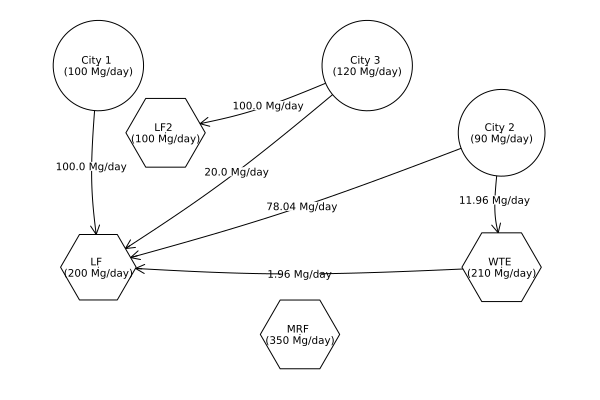

In [48]:
names = [
    "City 1 \n(" * string(city1_dict["production"], " Mg/day)"),
    "City 2 \n(" * string(city2_dict["production"], " Mg/day)"),
    "City 3 \n(" * string(city3_dict["production"], " Mg/day)"),
    "WTE \n(" * string(WTE_dict["capacity"], " Mg/day)"),
    "MRF \n(" * string(MRF_dict["capacity"], " Mg/day)"),
    "LF \n(" * string(LF_dict["capacity"], " Mg/day)"),
    "LF2 \n(" * string(LF2_dict["capacity"], " Mg/day)")
]

shapes = [:circle, :circle, :circle, :hexagon, :hexagon, :hexagon, :hexagon]
colors = [:white, :white, :white, :white, :white, :white, :white]
sizes = 0.15
xpos = [-0.5, 2.5, 1.5, 2.5, 1, -0.5, 0]
ypos = [1, 0.5, 1, -0.5, -1, -0.5, 0.5]

edge_labels = Dict(
    (city1, LF + cities) => string(value.(W[city1, LF]), " Mg/day"),
    (city2, WTE + cities) => string(value.(W[city2, WTE]), " Mg/day"),
    (city2, LF + cities) => string(value.(W[city2, LF]), " Mg/day"),
    (city3, LF + cities) => string(value.(W[city3, LF]), " Mg/day"),
    (city3, LF2 + cities) => string(value.(W[city3, LF2]), " Mg/day"),
    (WTE + cities, LF + cities) => string(value.(R[WTE, LF]), " Mg/day")
)
A = zeros(length(names), length(names))
[A[i[1], i[2]] = 1 for i in collect(keys(edge_labels))]

graphplot(A,
    names=names,
    edgelabel=edge_labels,
    markersizes=sizes,
    markershapes=shapes,
    markercolor=colors,
    x=xpos, y=ypos
)

#### Problem 2.4 (5 points)

Would you recommend that the cities build the new landfill? Why or why
not? Your answer should be based on your analysis but can draw on other
considerations as appropriate or desired.

## References

List any external references consulted, including classmates.